# Metadata

```yaml
Course:   DS 5001
Module:   12 Lab
Topc:     Sentiment and Plot in Novels
Author:   R.C. Alvarado
Date:     12 April 2023
```

**Purpose:** Explore ways to measure sentiment and track plot in all the novels.

# Set Up

## Config

In [1]:
data_dir = "../data"

In [2]:
lib_file = f'{data_dir}/syuzhet/combo-LIB.csv' # Also created in previous notebook

## Import

In [3]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
# import scipy.fftpack as fftpack # deprecated
import scipy.fft as fft

In [4]:
sns.set()

# Get the Books

Grab a subset of books to explore.

In [5]:
M = {
    bag:pd.read_pickle(f"{data_dir}/syuzhet/M_{bag}.pickle")
     for bag in "SENTS PARAS CHAPS".split()
}

In [6]:
M['SENTS']

term_str nrc_sentiment                   \
                                      count           sum      mean median   
book_id chap_num para_num sent_num                                           
105     1        1        0             102           0.0  0.000000    0.0   
                          1              11           0.0       NaN    NaN   
                 2        0               4           0.0       NaN    NaN   
                 3        0              16           1.0  1.000000    1.0   
                          1              39           0.0       NaN    NaN   
...                                     ...           ...       ...    ...   
usher   1        47       0              10          -1.0 -1.000000   -1.0   
                          1              17          -1.0 -0.333333   -1.0   
                          2              33          -2.0 -1.000000   -1.0   
                          3              43           1.0  1.000000    1.0   
                          4              73          -1.0 -0.200000   -1.0   

                                   bing_sentiment                   \
                                              sum      mean median   
book_id chap_num para_num sent_num                                   
105     1        1        0                  -5.0 -0.454545   -1.0   
                          1                   0.0       NaN    NaN   
                 2        0                   0.0       NaN    NaN   
                 3        0                   0.0       NaN    NaN   
                          1                  -2.0 -1.000000   -1.0   
...                                           ...       ...    ...   
usher   1        47       0                  -1.0 -1.000000   -1.0   
                          1                  -1.0 -1.000000   -1.0   
                          2                  -2.0 -1.000000   -1.0   
                          3                   1.0  1.000000    1.0   
                          4                  -1.0 -0.200000   -1.0   

                                   syu_sentiment                   \
                                             sum      mean median   
book_id chap_num para_num sent_num                                  
105     1        1        0                -2.05 -0.120588 -0.250   
                          1                 0.00       NaN    NaN   
                 2        0                 0.00       NaN    NaN   
                 3        0                 0.60  0.600000  0.600   
                          1                -0.50 -0.500000 -0.500   
...                                          ...       ...    ...   
usher   1        47       0                -1.80 -0.900000 -0.900   
                          1                -0.15 -0.050000 -0.250   
                          2                -1.85 -0.462500 -0.500   
                          3                 0.85  0.425000  0.425   
                          4                -1.15 -0.164286 -0.400   

                                   gi_sentiment                   
                                            sum      mean median  
book_id chap_num para_num sent_num                                
105     1        1        0                 2.0  0.333333    1.0  
                          1                 0.0       NaN    NaN  
                 2        0                 0.0       NaN    NaN  
                 3        0                 0.0       NaN    NaN  
                          1                 0.0       NaN    NaN  
...                                         ...       ...    ...  
usher   1        47       0                -2.0 -1.000000   -1.0  
                          1                -2.0 -1.000000   -1.0  
                          2                 0.0  0.000000    0.0  
                          3                 1.0  1.000000    1.0  
                          4                 1.0  0.200000    1.0  

[181987 rows x 13 columns]

In [7]:
LIB = pd.read_csv(lib_file).set_index('book_id')

In [8]:
LIB.head(10)

,author_id,title,corpus
book_id,,,
secretadversary,christie,secretadversary,novels
styles,christie,styles,novels
moonstone,collins,moonstone,novels
adventures,doyle,adventures,novels
baskervilles,doyle,baskervilles,novels
scarlet,doyle,scarlet,novels
signoffour,doyle,signoffour,novels
marieroget,poe,marieroget,novels
ruemorgue,poe,ruemorgue,novels


# Define Classes

**Jockers' original FFT function params**

<table>
    <tr><td>raw_values</td><td>the raw sentiment values calculated for each sentence</td></tr>
    <tr><td>low_pass_size</td><td>The number of components to retain in the low pass filtering. Default = 3</td></tr>
    <tr><td>x_reverse_len</td><td>the number of values to return. Default = 100</td></tr>
    <tr><td>padding_factor</td><td>the amount of zero values to pad raw_values with, as a factor of the size of raw_values. Default = 2.</td></tr>
    <tr><td>scale_vals</td><td>Logical determines whether or not to normalize the values using the scale function Default = FALSE. If TRUE, values will be scaled by subtracting the means and scaled by dividing by their standard deviations. See ?scale</td></tr>
    <tr><td>scale_range</td><td>Logical determines whether or not to scale the values from -1 to +1. Default = FALSE. If set to TRUE, the lowest value in the vector will be set to -1 and the highest values set to +1 and all the values scaled accordingly in between.</td></tr>
</table>    

Fast Fourier Transform. See https://rdrr.io/cran/syuzhet/man/get_transformed_values.html

In [9]:
class Transforms:
    
    def FFT(raw_values, 
               low_pass_size=3, 
               x_reverse_len=100,  
               padding_factor=2, 
               scale_values=False, 
               scale_range=False):

        if low_pass_size > len(raw_values):
            sys.exit("low_pass_size must be less than or equal to the length of raw_values input vector")

        raw_values_len = len(raw_values)
        padding_len = raw_values_len * padding_factor

        # Add padding, then fft
        # values_fft = fftpack.fft(raw_values, padding_len)
        values_fft = fft.fft(raw_values, padding_len)
        low_pass_size = low_pass_size * (1 + padding_factor)
        keepers = values_fft[:low_pass_size]

        # Preserve frequency domain structure
        modified_spectrum = list(keepers) \
            + list(np.zeros((x_reverse_len * (1+padding_factor)) - (2*low_pass_size) + 1)) \
            + list(reversed(np.conj(keepers[1:(len(keepers))])))

        # Strip padding
        # inverse_values = fftpack.ifft(modified_spectrum)
        inverse_values = fft.ifft(modified_spectrum)
        inverse_values = inverse_values[:x_reverse_len]

        transformed_values = np.real(tuple(inverse_values))
        return transformed_values        
        
    def DCT(raw_values, 
                  low_pass_size=5, 
                  x_reverse_len=100,
                  dct_type=3):
        if low_pass_size > len(raw_values):
            raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
        # values_dct = fftpack.dct(raw_values, type = dct_type) # 2 or 3 works well
        print("USING NEW")
        values_dct = fft.dct(raw_values, type = dct_type) # 2 or 3 works well
        keepers = values_dct[:low_pass_size]
        padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
        # dct_out = fftpack.idct(padded_keepers)
        dct_out = fft.idct(padded_keepers)
        return dct_out

In [10]:
class SyuzhetBook:
    
    M = None
    LIB = None

    def __init__(self, book_id, bag='SENTS', src='nrc', agg='sum'):
        self.book_id = book_id
        self.book_title = self.LIB.loc[str(book_id)].title
        
        self.bag = 'SENTS'
        self.src = 'nrc'
        self.agg = 'sum'
        
        self.S = self.M[bag].loc[self.book_id, f"{src}_sentiment"][agg].reset_index(drop=True)
        print(self.book_id, self.book_title, self.bag, self.src, self.agg)
        
    def plot_raw(self):

        plot_cfg = dict(
            figsize=(25, 5), 
            legend=False, 
            fontsize=16)
        
        self.S.plot(**plot_cfg)
        
    def plot_smooth(self, 
                 method='DCT', 
                 low_pass_size=6, 
                 x_reverse_len=100):

        plot_cfg = dict(
            figsize = (25, 5), 
            legend = False, 
            fontsize = 16,
            title = f"{self.book_title}: {self.src} ({self.agg})"
        )

        if method == "DCT":
            X = Transforms.DCT(self.S.values, low_pass_size=low_pass_size, x_reverse_len=x_reverse_len)
        elif method == "FFT":
            X = Transforms.FFT(self.S.values, low_pass_size=low_pass_size, x_reverse_len=x_reverse_len, padding_factor = 1)

        # Scale Range
        X = (X - X.mean()) / X.std()

        pd.Series(X).plot(**plot_cfg);
        
    def plot_rolling(self, 
                         win_type='cosine', 
                         win_div=3,
                         norm=None):
        
        window = round(self.S.shape[0]/win_div)
        plot_title = self.book_title + f'  (rolling; div={win_div}, w={window}, {self.src}, agg={self.agg})'
        self.S.rolling(window, win_type=win_type).mean().plot(figsize=(25,5), title=plot_title)
        # ax.set_title(plot_title, fontsize=20)


# Explore 

In [11]:
# LIB

In [12]:
SyuzhetBook.M = M
SyuzhetBook.LIB = LIB

## Persuasion

In [13]:
pg105 = SyuzhetBook(105)

105 PERSUASION SENTS nrc sum


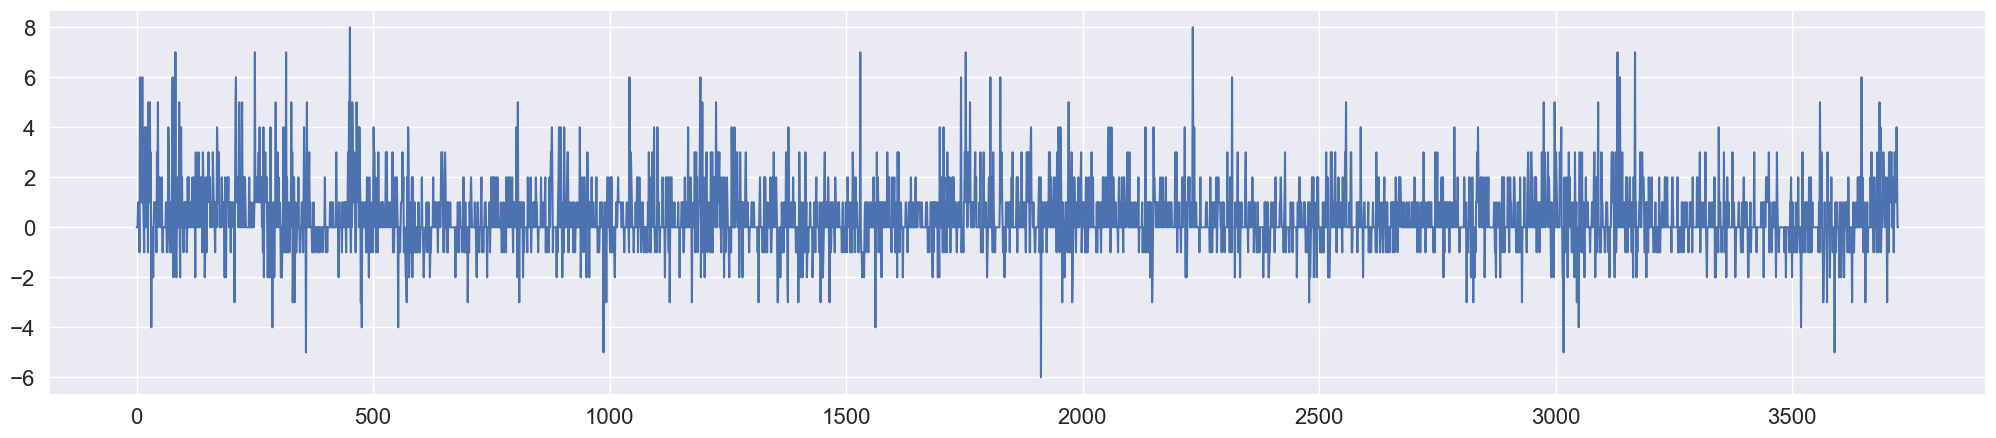

In [14]:
pg105.plot_raw()

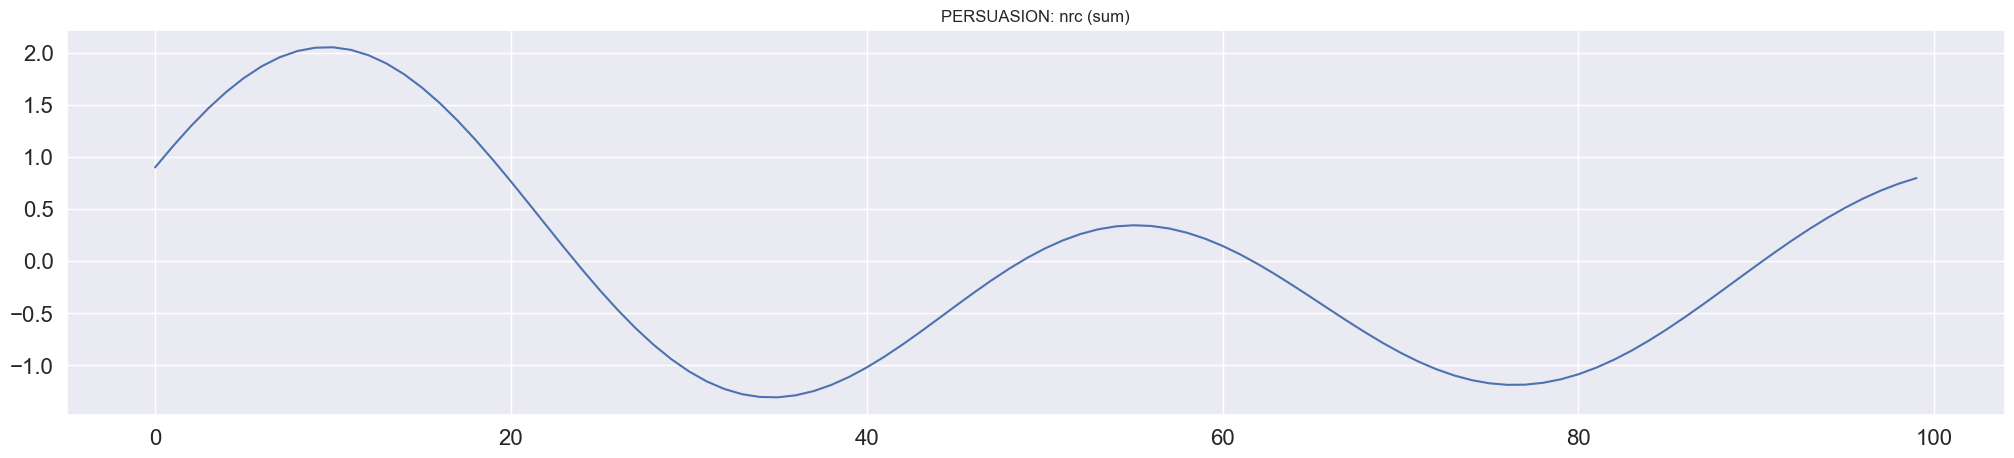

In [15]:
pg105.plot_smooth('FFT', low_pass_size=3)

USING NEW


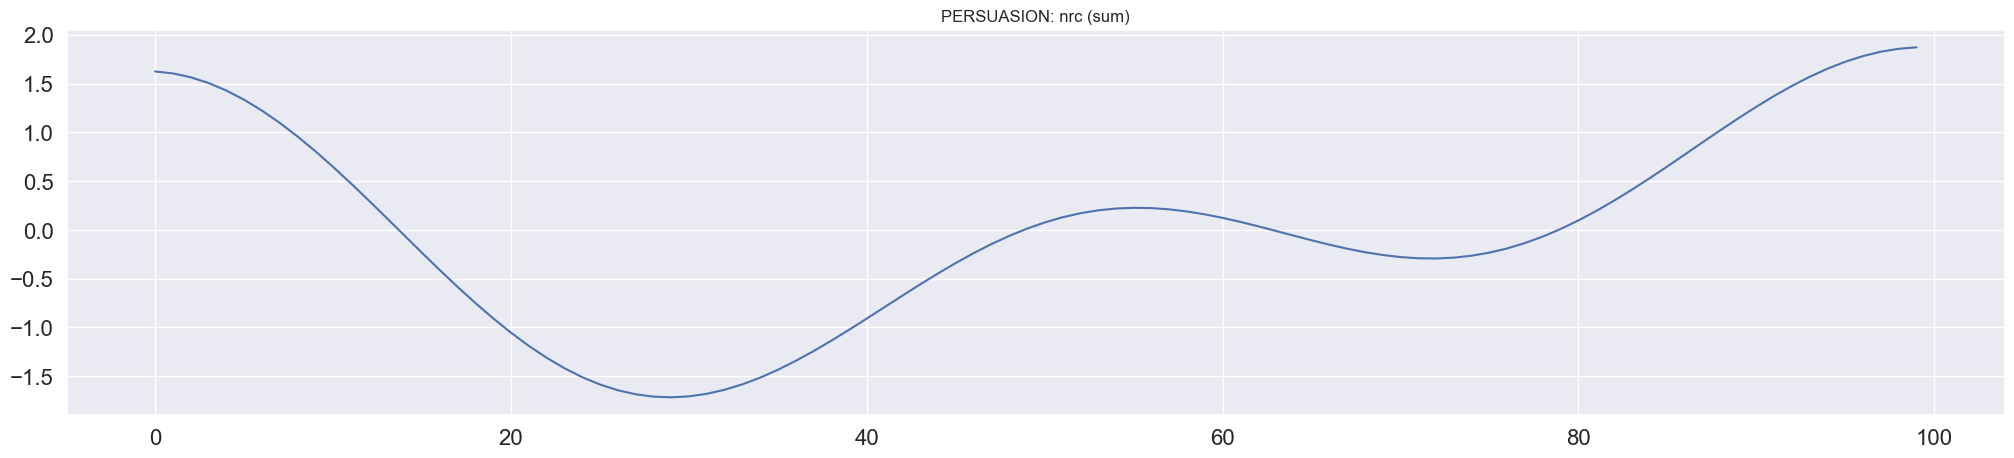

In [16]:
pg105.plot_smooth()

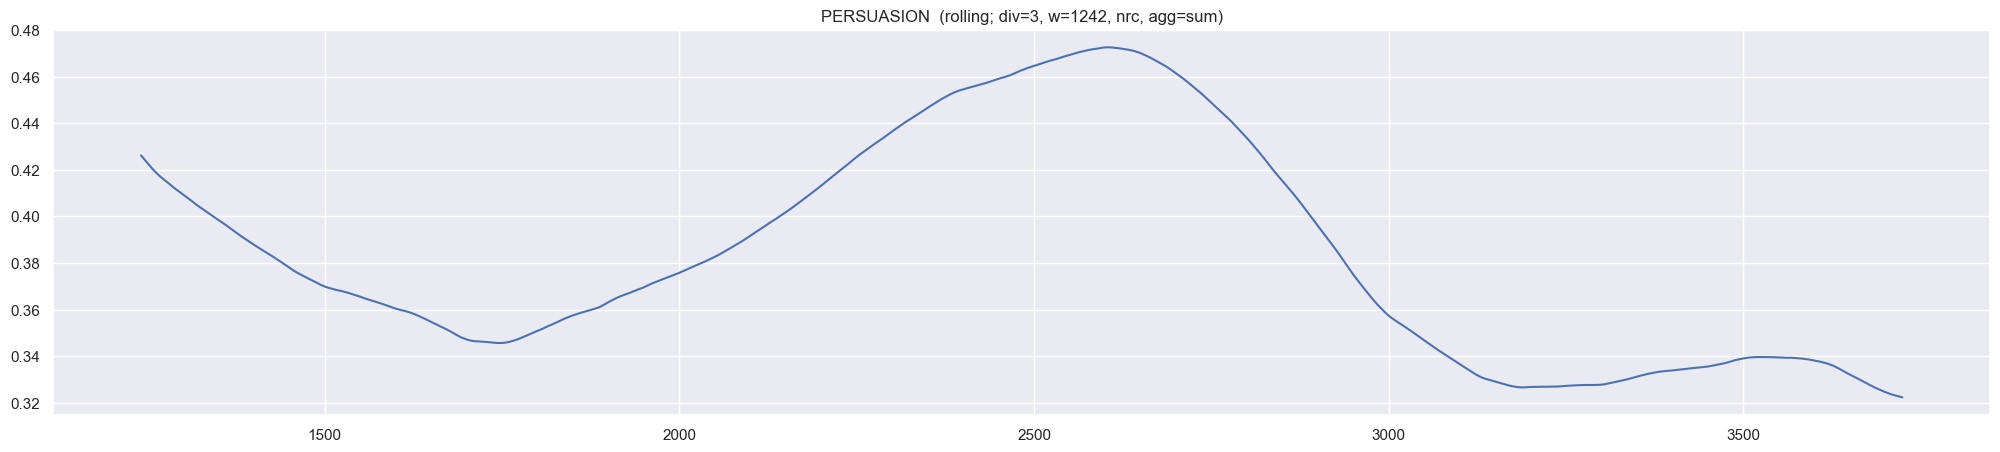

In [17]:
pg105.plot_rolling()

## Persuasion by PARAS

In [18]:
pg105_paras = SyuzhetBook(105, bag='PARAS')

105 PERSUASION SENTS nrc sum


USING NEW


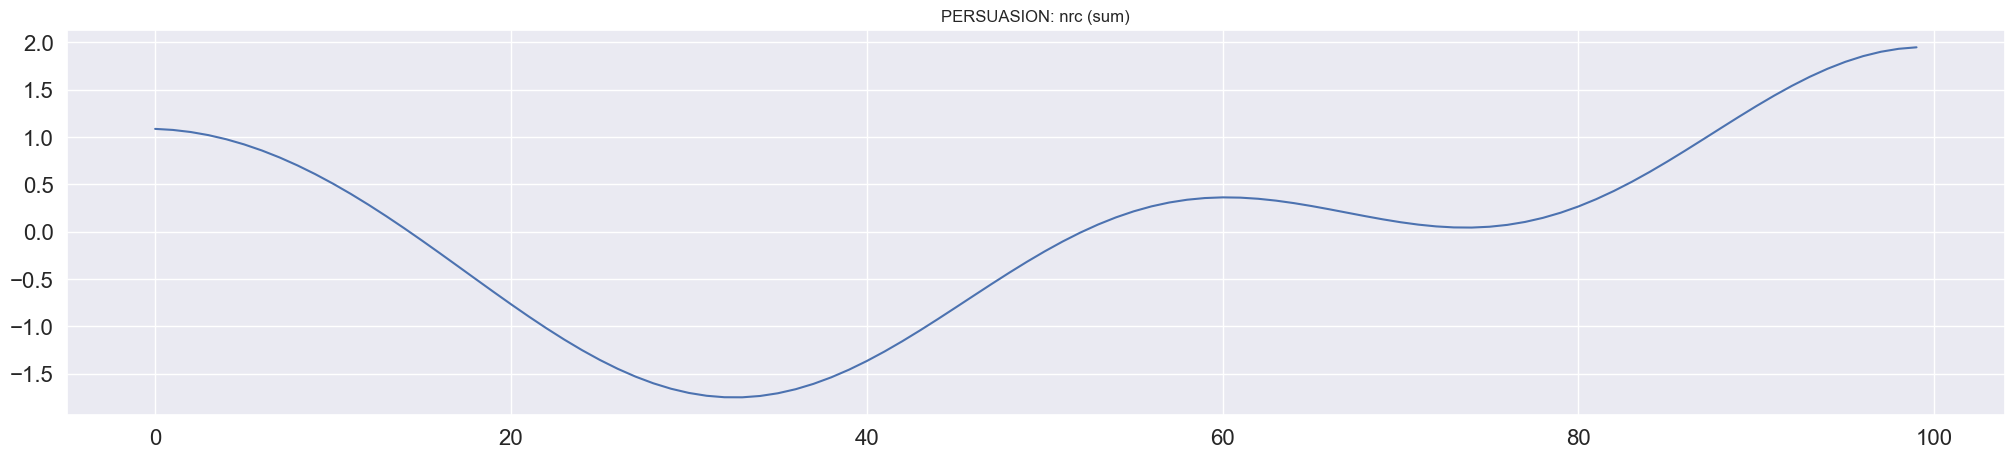

In [19]:
pg105_paras.plot_smooth()

## Moby Dick

In [20]:
pg2701 = SyuzhetBook(2701)

2701 MOBY DICK OR THE WHALE SENTS nrc sum


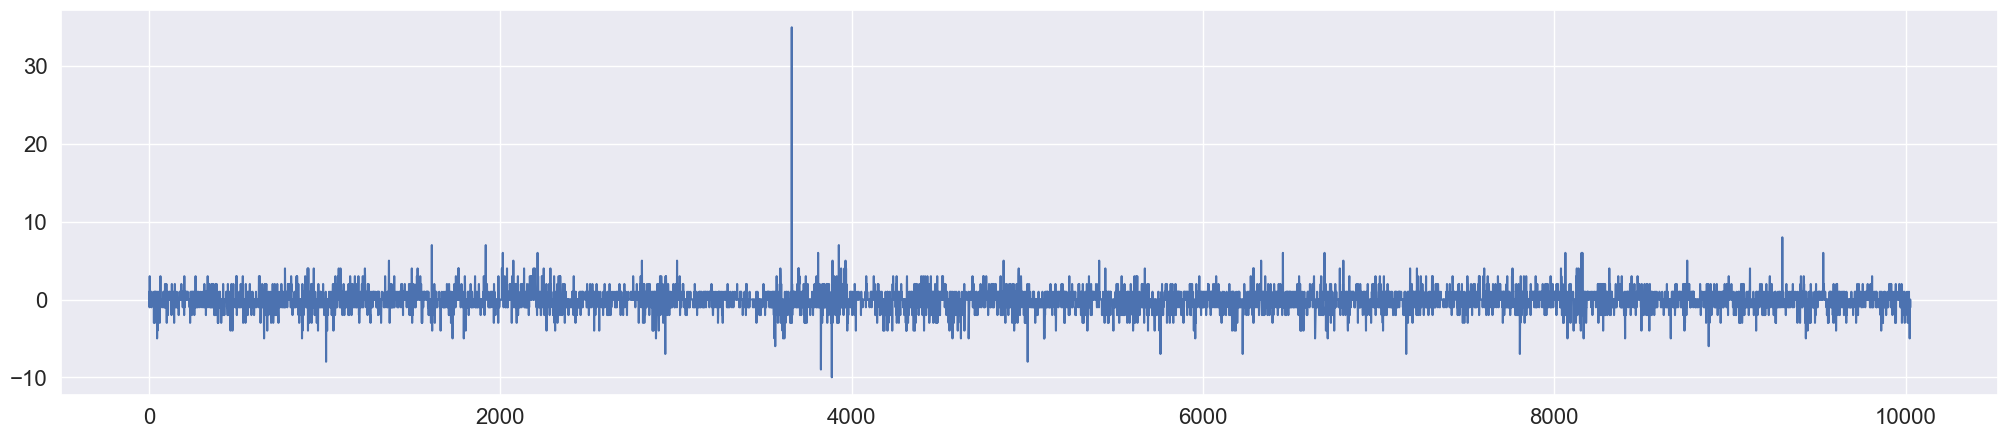

In [21]:
pg2701.plot_raw()

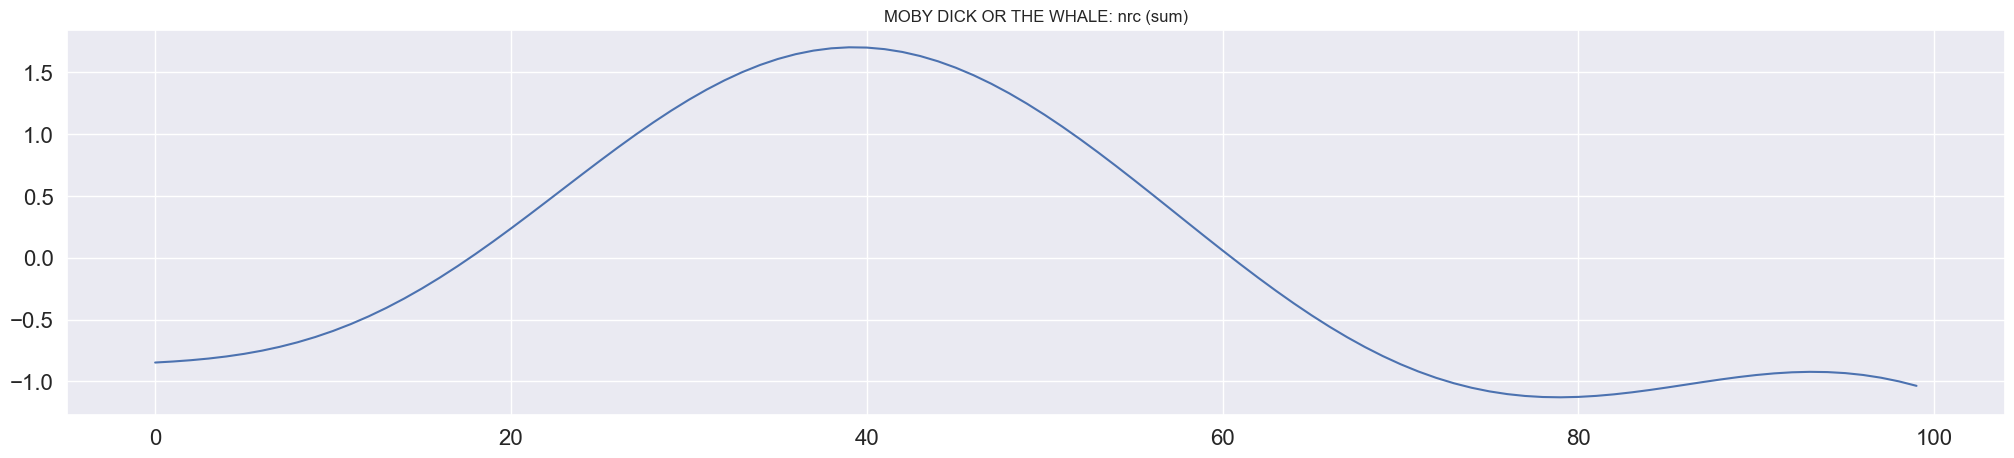

In [22]:
pg2701.plot_smooth('FFT', low_pass_size=3)

USING NEW


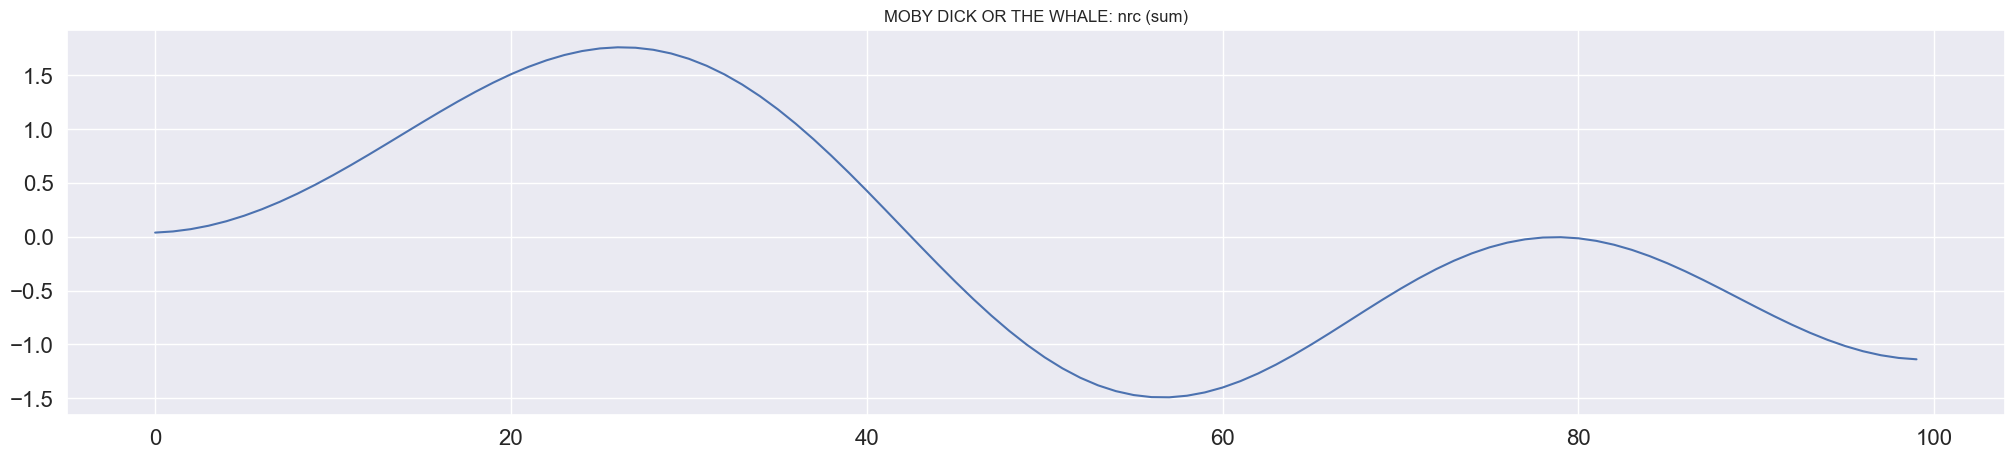

In [23]:
pg2701.plot_smooth()

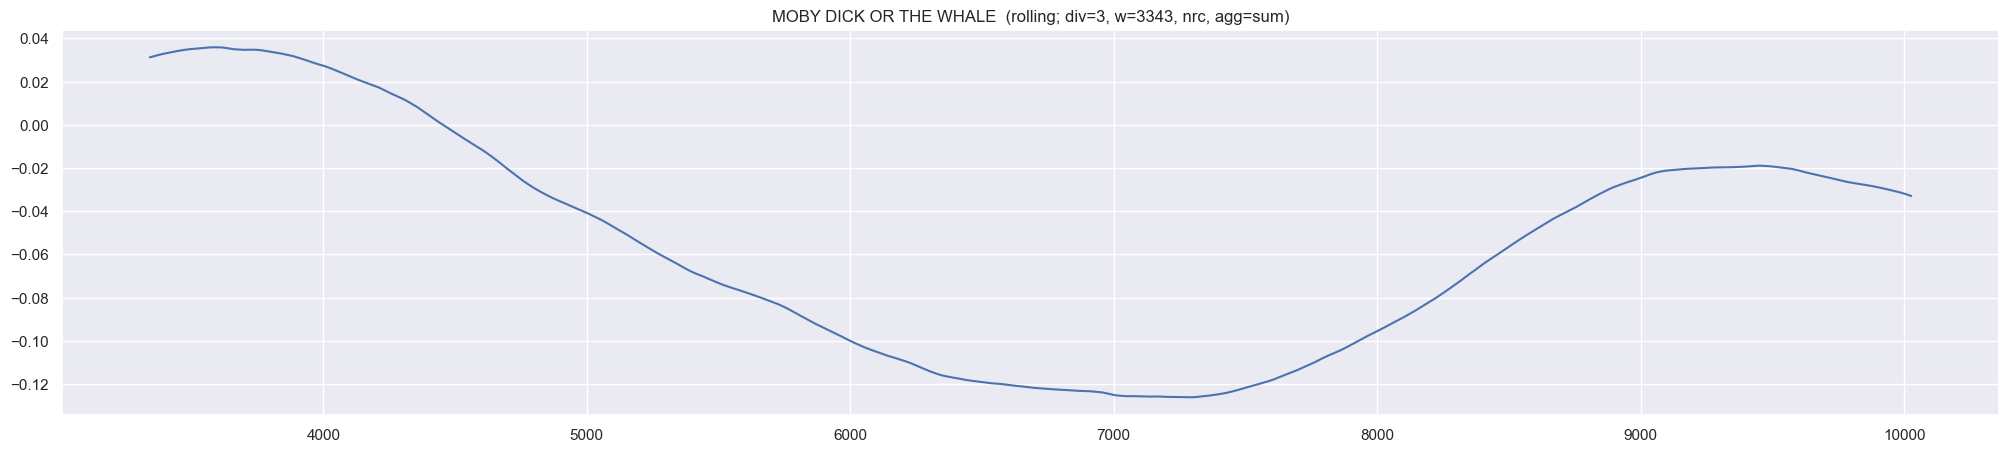

In [24]:
pg2701.plot_rolling()

## Frankenstein

In [25]:
frankenstein = SyuzhetBook('frankenstein')

frankenstein frankenstein SENTS nrc sum


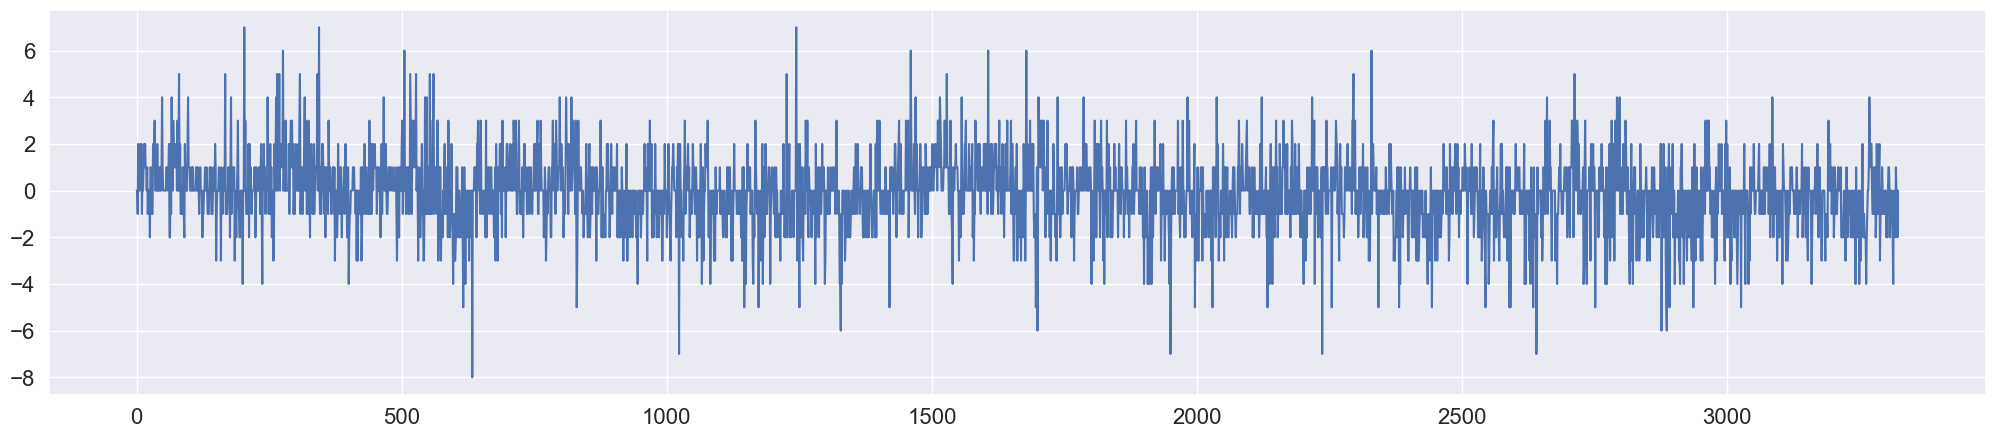

In [26]:
frankenstein.plot_raw()

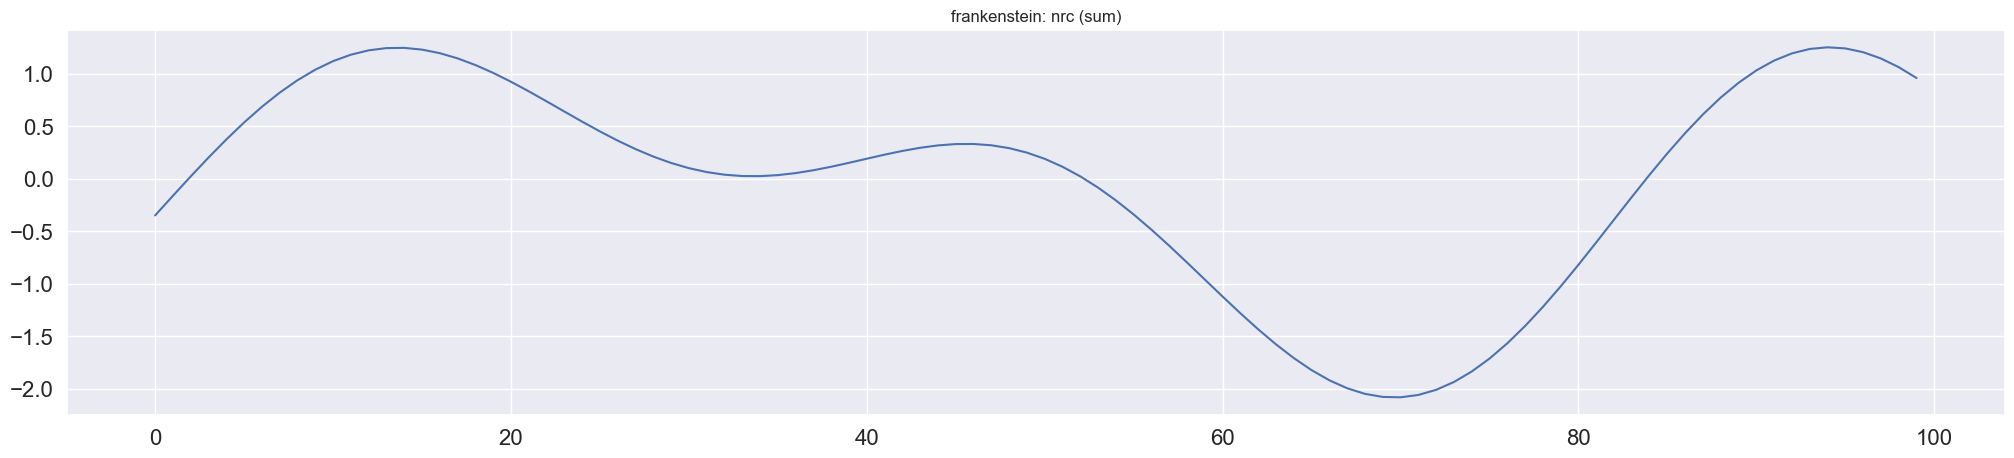

In [27]:
frankenstein.plot_smooth('FFT', low_pass_size=3)

USING NEW


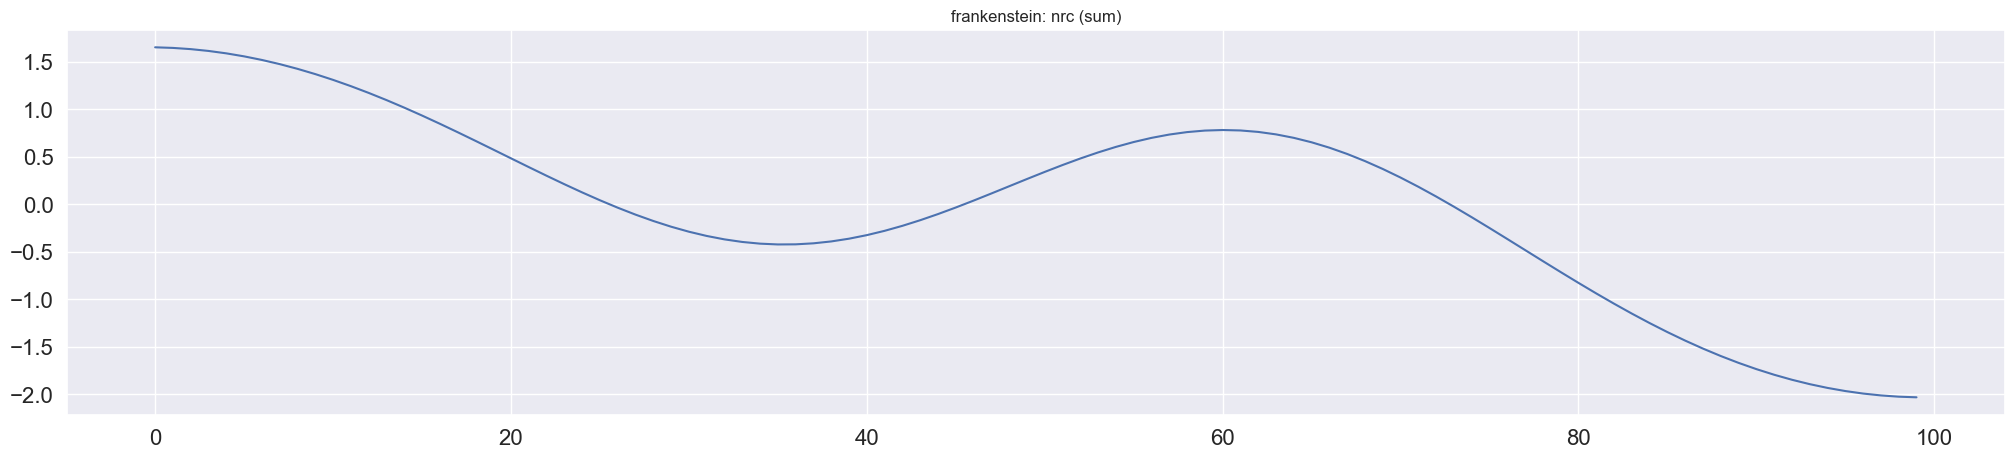

In [28]:
frankenstein.plot_smooth()

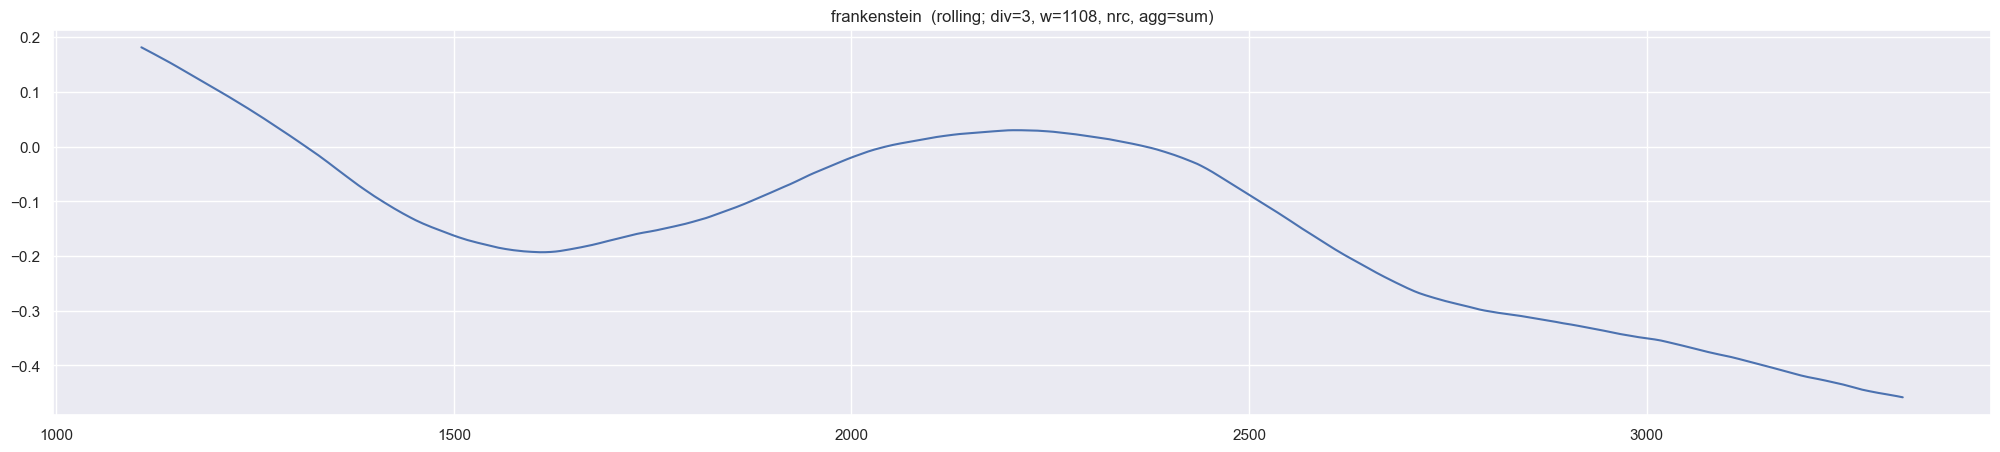

In [29]:
frankenstein.plot_rolling()

## Dracula

In [30]:
dracula = SyuzhetBook('dracula')

dracula dracula SENTS nrc sum


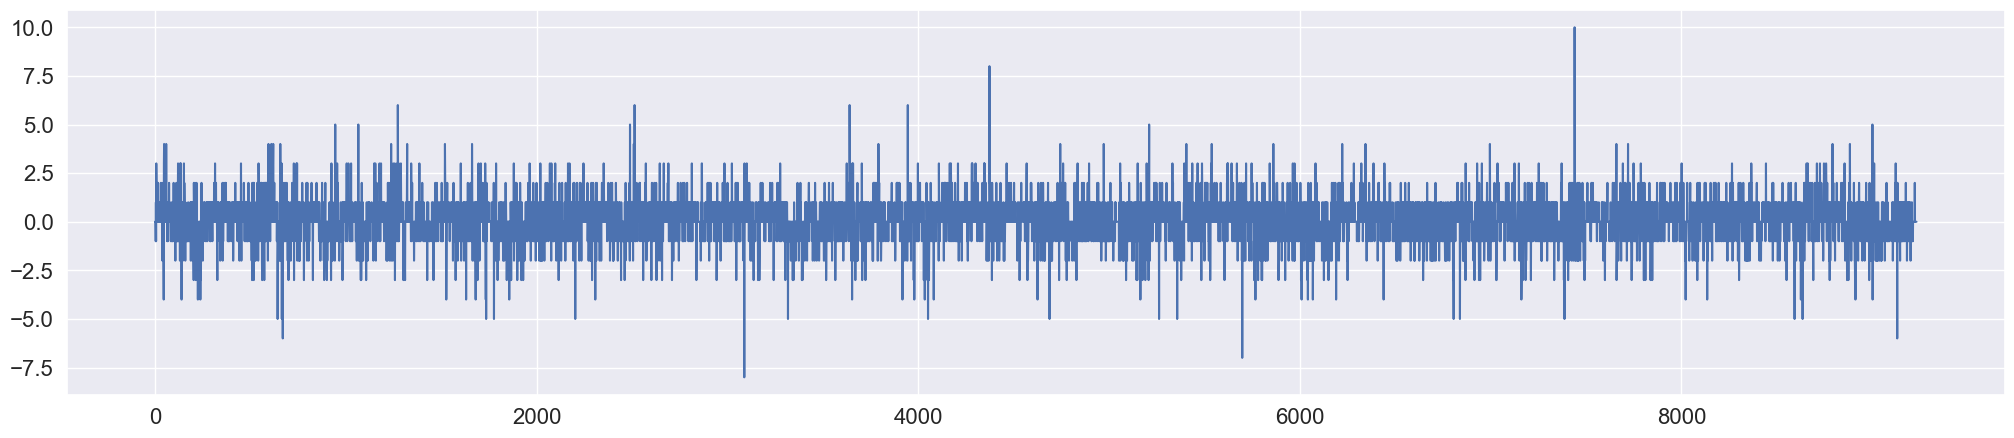

In [31]:
dracula.plot_raw()

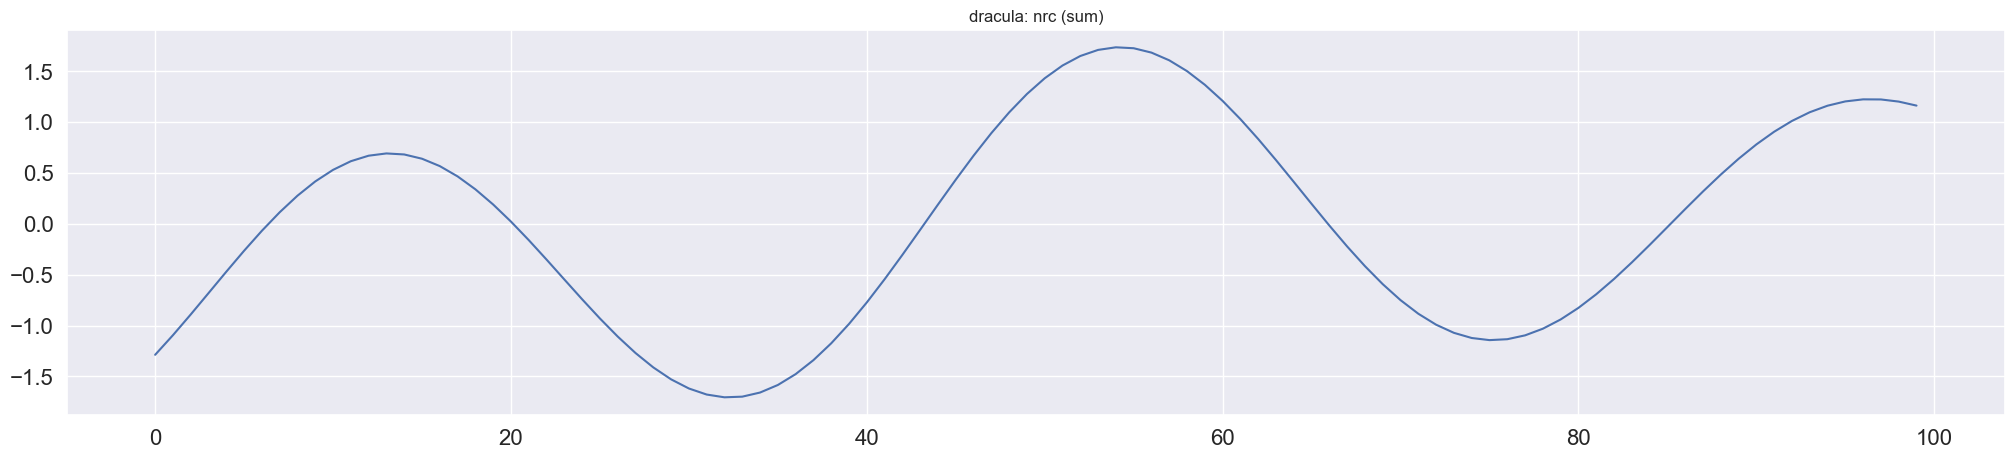

In [32]:
dracula.plot_smooth('FFT', low_pass_size=3)

USING NEW


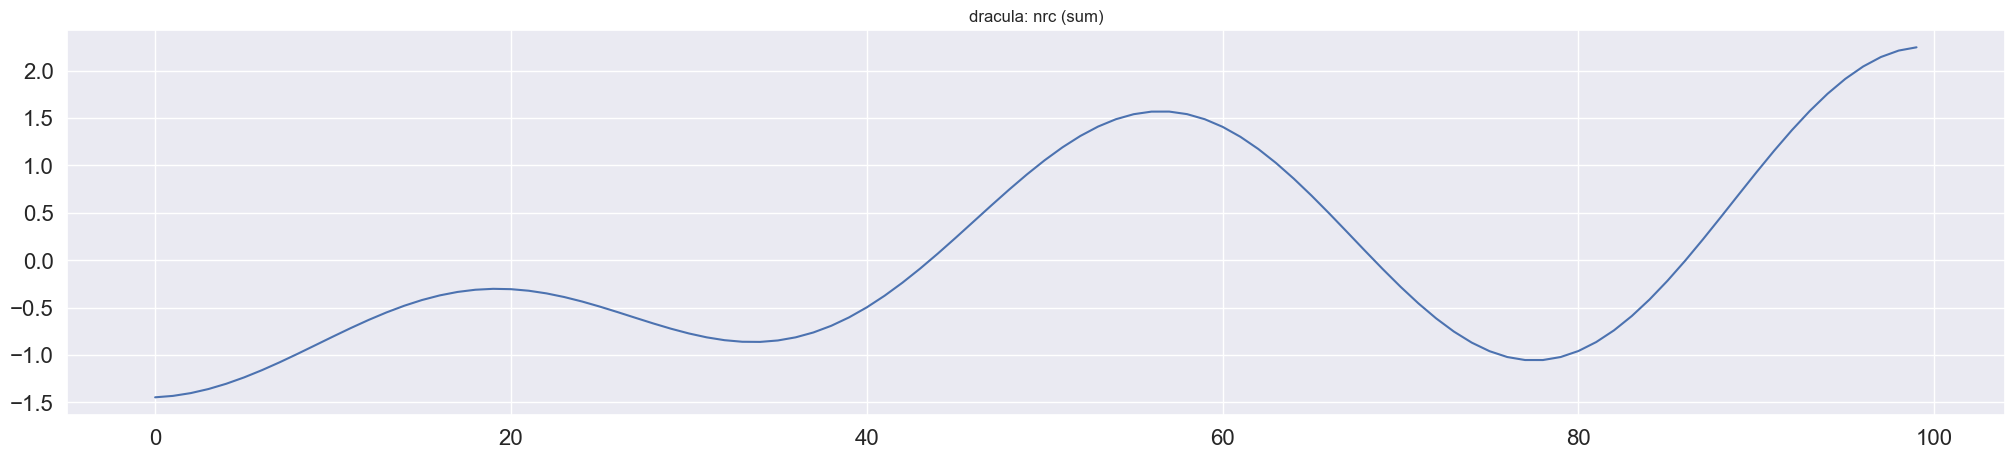

In [33]:
dracula.plot_smooth()

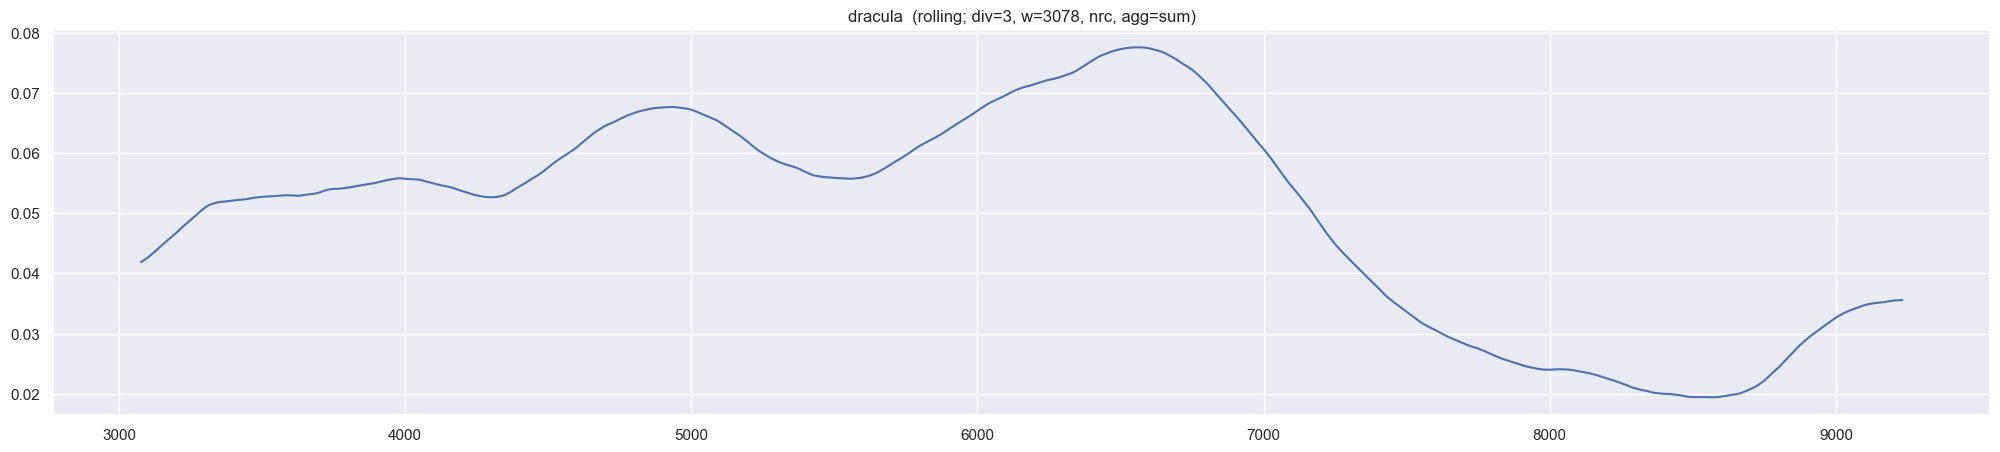

In [34]:
dracula.plot_rolling()

## Pride and Prejudice

In [35]:
pg1342 = SyuzhetBook(1342)

1342 PRIDE AND PREJUDICE SENTS nrc sum


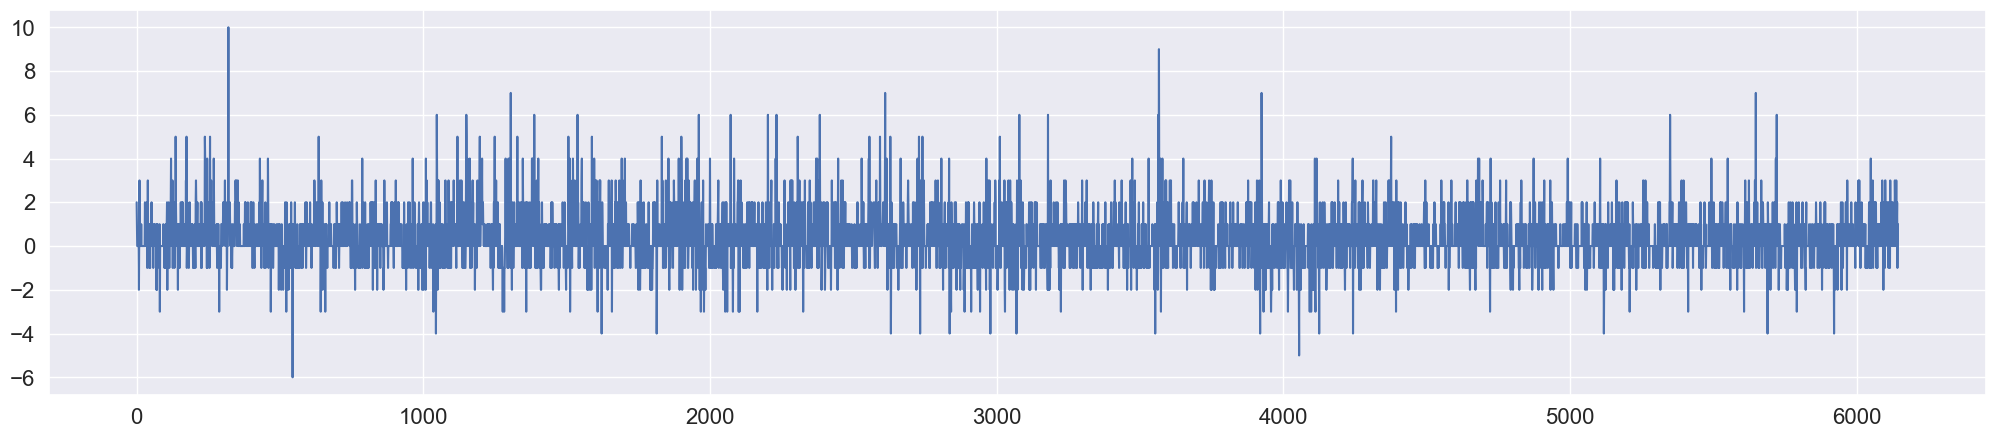

In [36]:
pg1342.plot_raw()

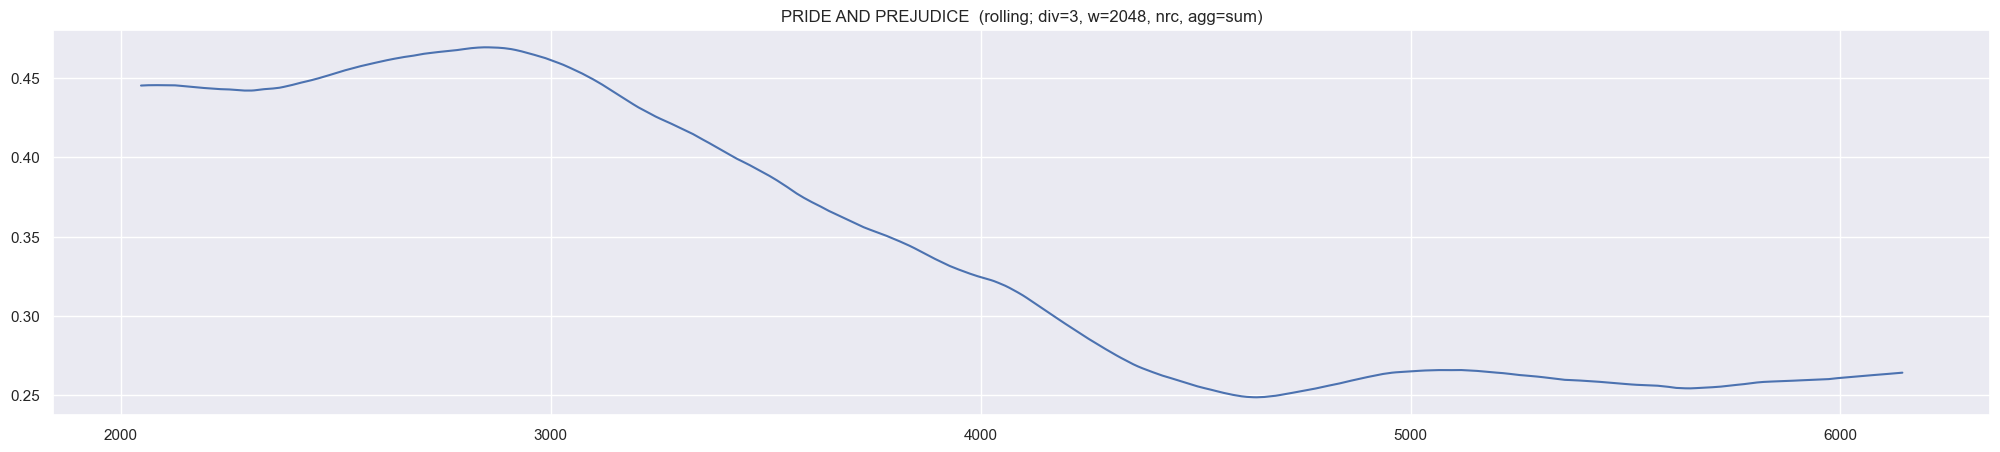

In [37]:
pg1342.plot_rolling()

USING NEW


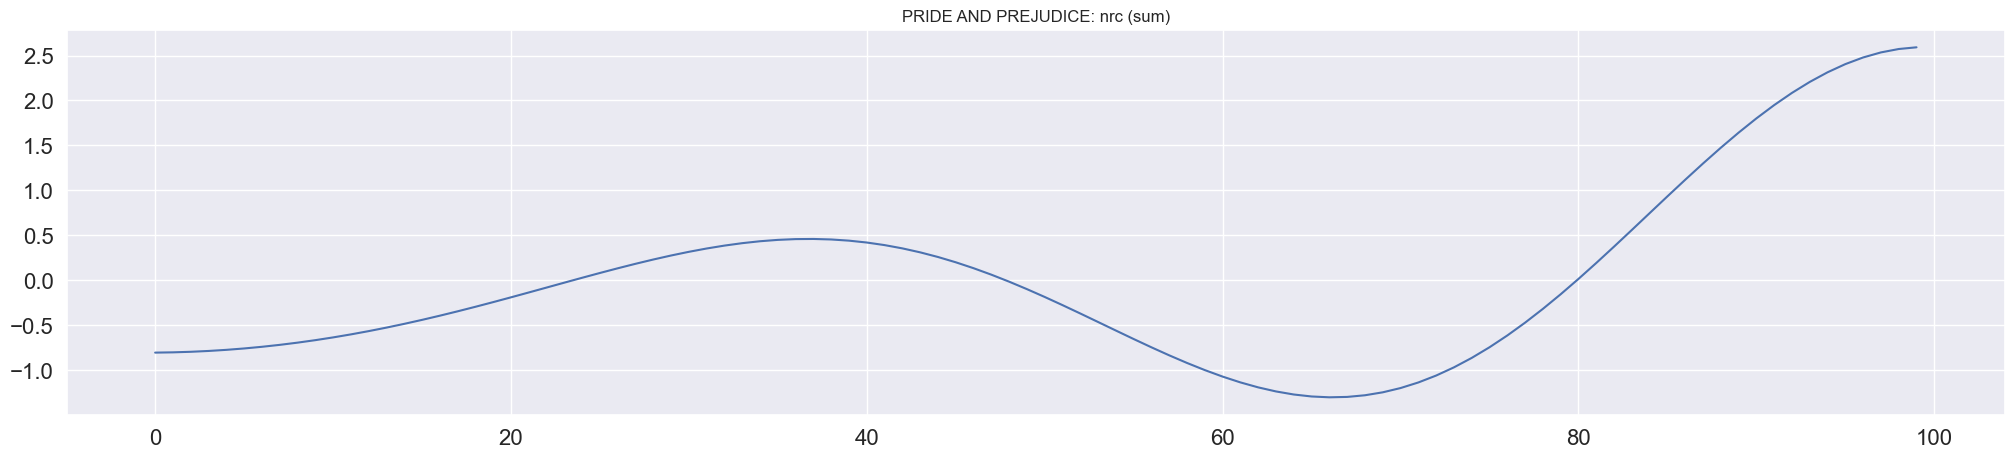

In [38]:
pg1342.plot_smooth()

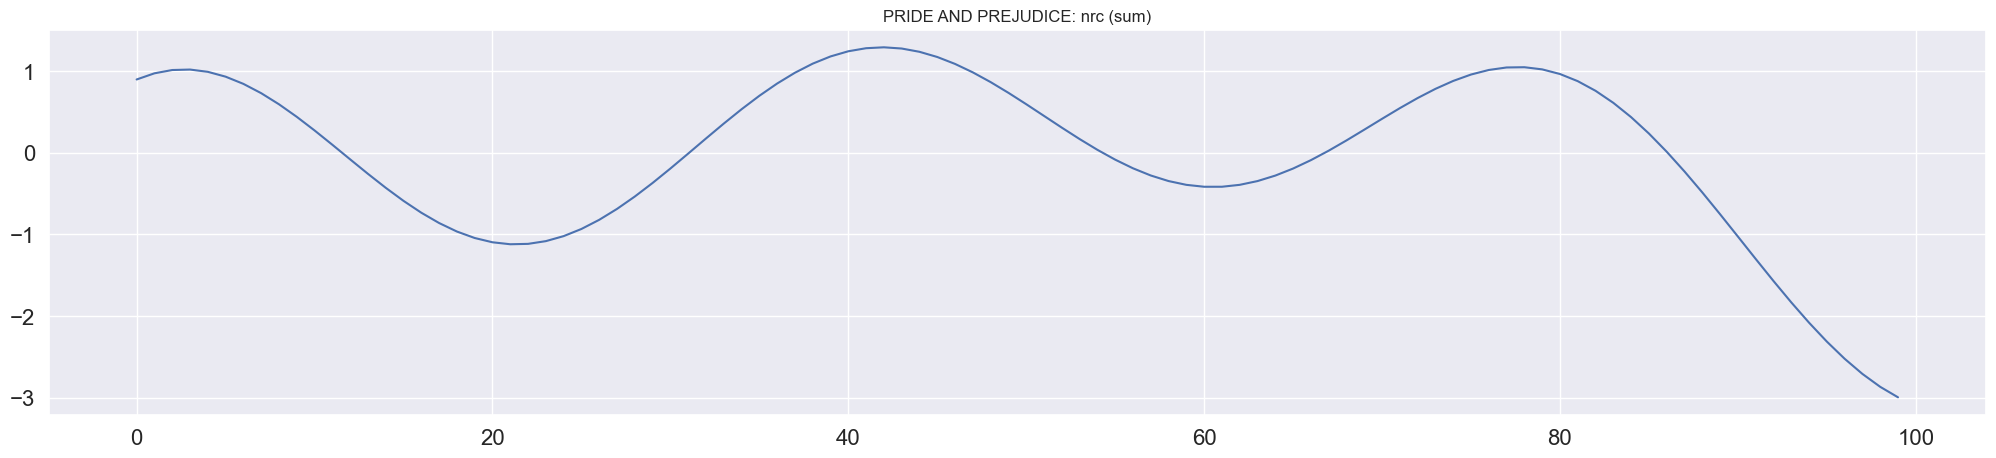

In [39]:
pg1342.plot_smooth('FFT', low_pass_size=3)

## Northanger Abbey

In [40]:
northangerabbey = SyuzhetBook('northangerabbey')

northangerabbey northangerabbey SENTS nrc sum


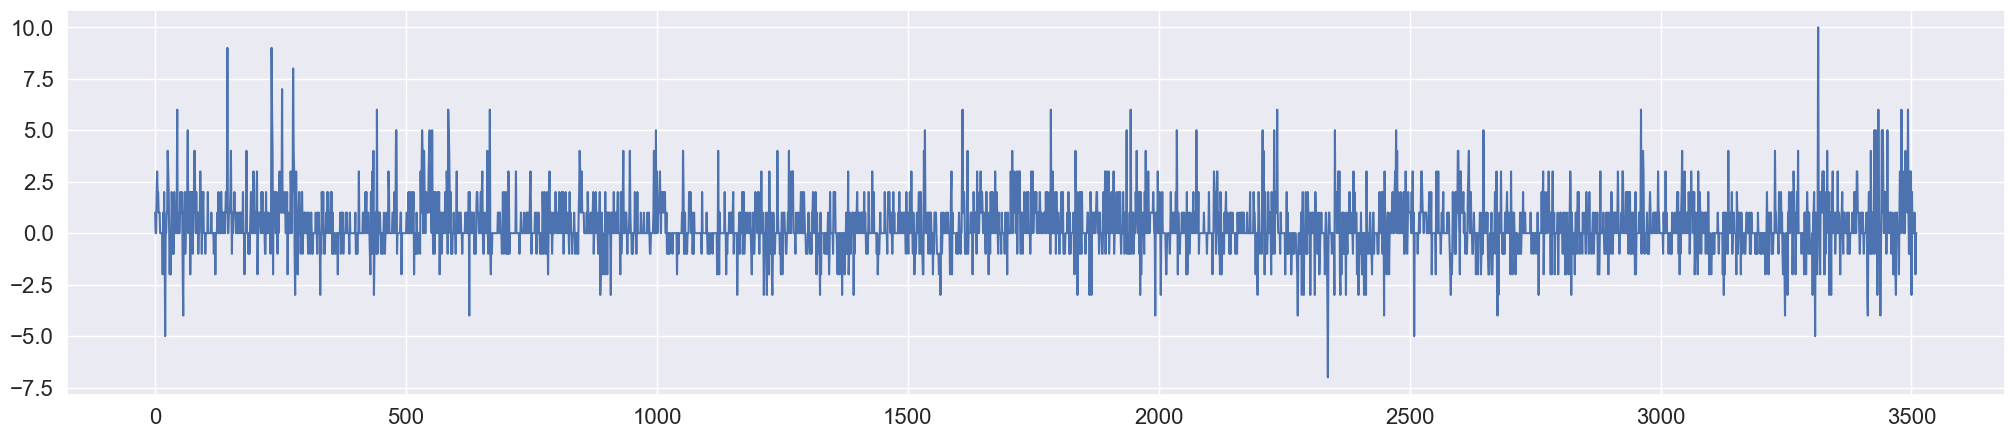

In [41]:
northangerabbey.plot_raw()

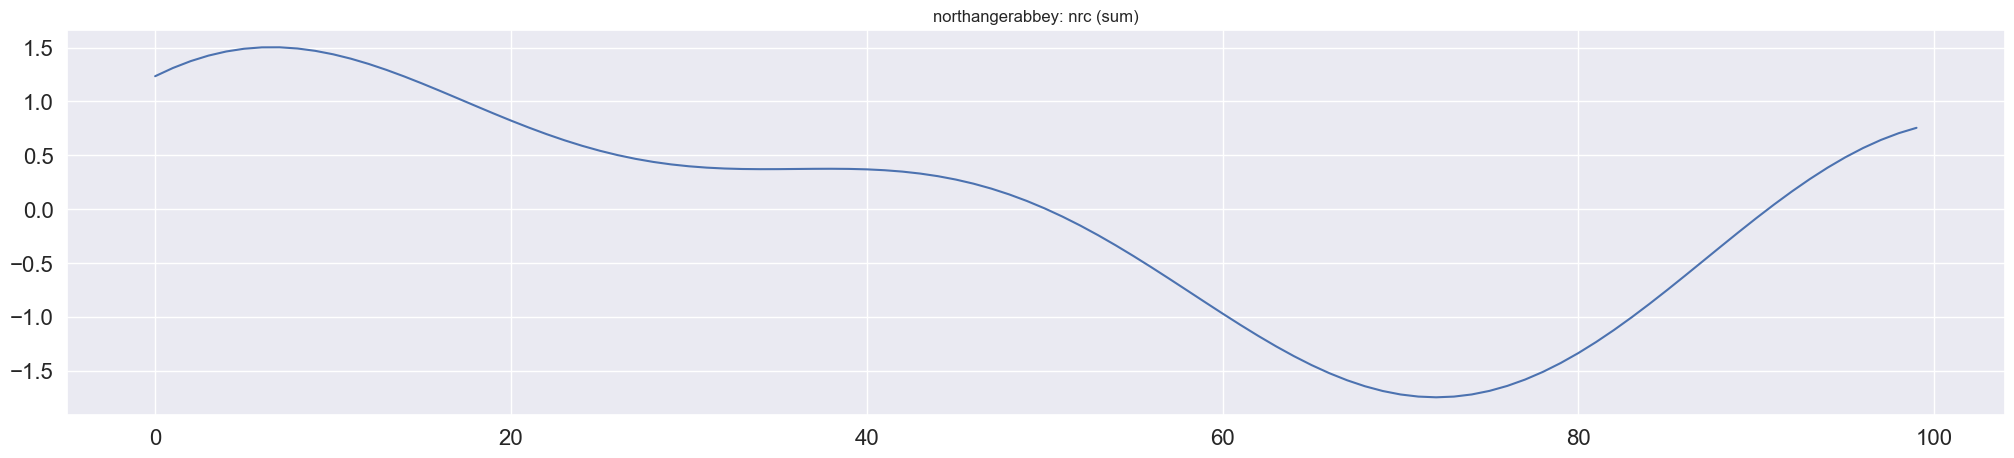

In [42]:
northangerabbey.plot_smooth('FFT', low_pass_size=3)

USING NEW


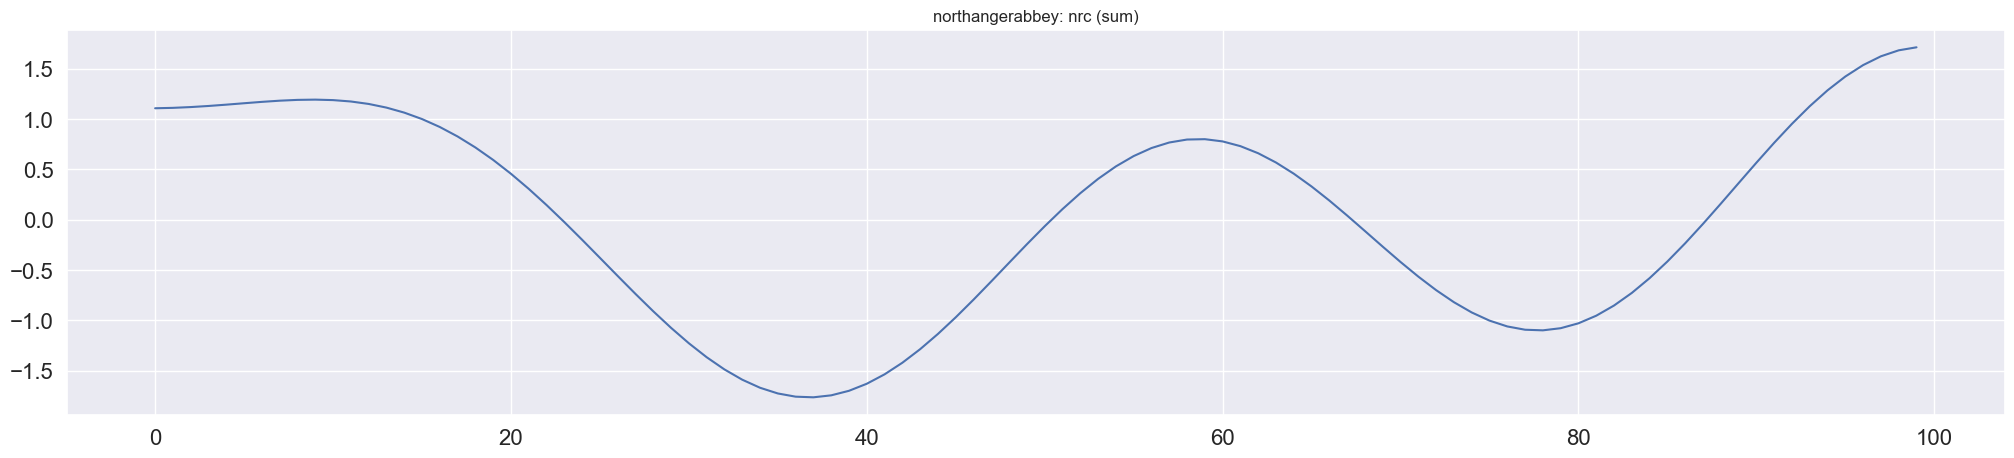

In [43]:
northangerabbey.plot_smooth()

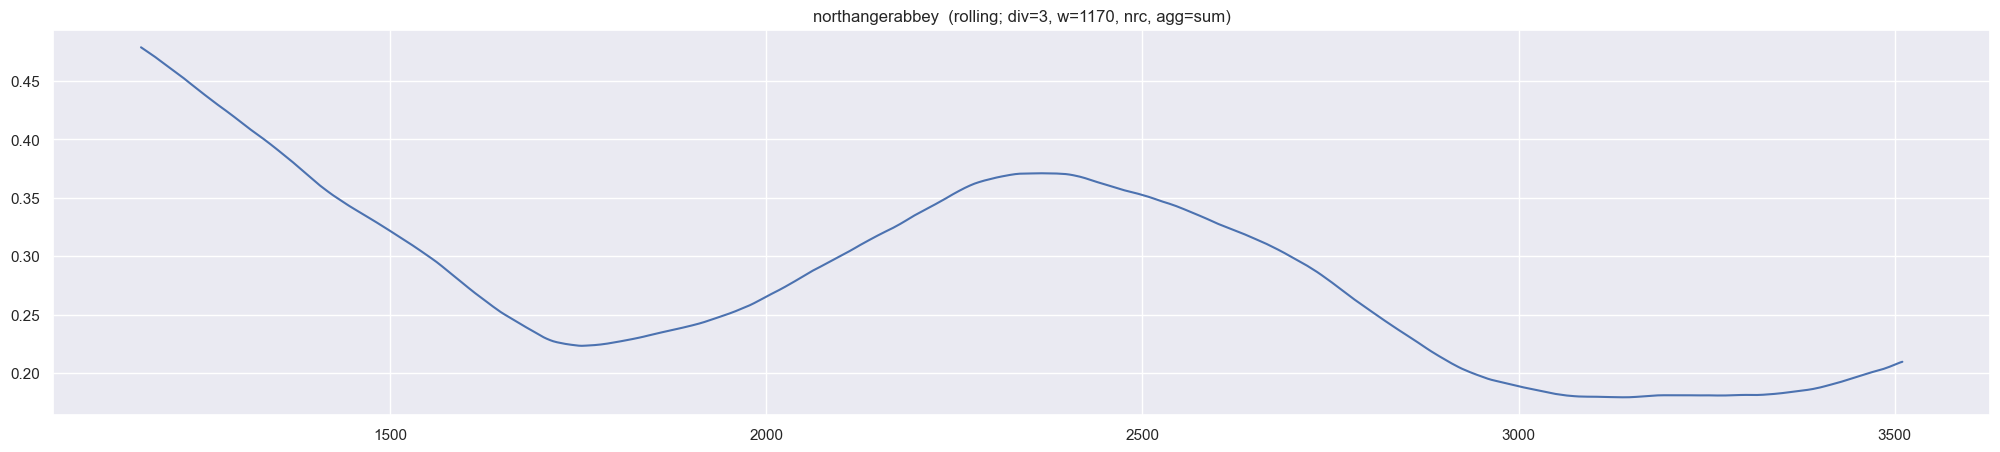

In [44]:
northangerabbey.plot_rolling()

**Federalist**:
> In the end, the two are wed. In the final pages of “Northanger Abbey,” Austen writes that the couple was brought together through mutual affection and that Henry Tinley’s affection for Catherine is rooted in gratitude for her feelings for him. **She’s implying that the typically overwrought and dramatic type of romance on display in most fictitious works does not hold a candle to real love that is rooted in a commitment to one’s husband or wife.** Happy endings and “perfect happiness” are often brought about through ordinary and conventional means — means that ought not to be dismissed because they are **less sexy** than the conventions used in a Gothic novel. \
https://thefederalist.com/2018/10/09/jane-austen-pulled-off-feat-genius-northanger-abbey/

**Schmoop**:

>Northanger Abbey has **a very neat and tidy and rather clichéd ending**: all the nice main characters get married to other nice characters and live happily ever after. All the mean characters end up alone. It's like a Disney movie.\
\
Aside from being rather predictable, **this ending is also a little weird**. What's odd about this ending is that the entire novel spends a lot of time undermining the various clichés of popular Gothic novels. But it ends with a series of giant clichés, including a deus ex machina, which is a fancy Latin term meaning a convenient plot element that is dropped in out of nowhere. The deus ex machina here is that one of the nice and long suffering characters happens to marry a wealthy Viscount who has never before been mentioned. It's completely random. And the narrator even admits that this is pretty weird and random. \
\
The novel's ending isn't just clichéd, **it's totally over-the-top clichéd**. So, rather than being out of step with the rest of the book, the ending actually bumps the satire up a notch and goes for broke. Like the rest of the book, the ending is still highly satirical – **it exaggerates and mocks the types of sentimental and even ludicrous endings often found in Gothic novels**. The ending just accomplishes the satire in a different way than the rest of the book, which relies more on clever dialogue and humorously disrupted expectations. Instead of letting the characters supply the humor through their words and actions, the ending utilizes outrageous plot devices and ironic narrative commentary. Still, why Jane Austen decided to go with an over-the-top ending instead of a more subtle ending is debatable.\
https://www.shmoop.com/study-guides/literature/northanger-abbey/analysis/ending